# uploading data

In [2]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import xmltodict
from numcodecs import Blosc
import numpy as np
import zarr as zarr
import tifffile as tf
from PIL import Image as im
import cv2 
from skimage.io import imread
from skimage.exposure import cumulative_distribution #calculate the cumulative pixel value
import imagecodecs
from skimage import exposure
from skimage.exposure import match_histograms
import pandas as pd
import os

In [3]:
polaris=tf.imread('/uftp/src/lowest_levels/polaris.tif')
huron_101010=tf.imread('/uftp/src/lowest_levels/huron_IHC_101010.tif')
huron_111219=tf.imread('/uftp/src/lowest_levels/huron_IHC_111219.tif')

a1 circles from palletes

In [4]:
polaris_a1=polaris[455:590, 100:235, :]
#plt.imshow(polaris_a1)

In [5]:
huron_a1_10=huron_101010[303:438, 64:199, :]
#plt.imshow(huron_a1_10)

In [6]:
huron_a1_3gammas=huron_111219[205:340, 488:623, :]
#plt.imshow(huron_a1_3gammas)

# gammas

In [7]:
#transfer function
def transfer_function(img, values, mode='linearization'):
  '''
  This function takes the image and performs transformation based on two modes: default 'linearization' outputs image with 1.0 gamma,
  any other input for 'mode' (e.g. 'correction') applies gamma(s) to an image. Single float/int number or list of numbers can be inputed
  as 'values' parameter (see dictionary below). 
  Gamma values: {'polaris_NTSC': 1.8, 'huron_sRGB_10_10_10': 2.2, 'huron_sRGB_11_12_19': [1.1, 1.2, 1.9]}
  '''

  img_norm=img/255.0 #converts array values from 0-255 range to 0-1
  if isinstance(values, (float, int)): #this part is needed to handle both single numbers and a list of gammas
    values = [values]
  if len(values)!=1:
    transposed=np.transpose(img_norm, (2,0,1)) #dimension with color channels becomes the first in order
    modified=np.empty_like(transposed)
    for i, gamma in enumerate(values):
      modified[i]=transposed[i]**(gamma if mode == 'linearization' else 1/gamma)
    modified=np.transpose(modified, (1,2,0))
  else:
    gamma = values[0]
    modified=img_norm**(gamma if mode == 'linearization' else 1/gamma)

  modified=(modified*255).astype(np.uint8)
  plt.imshow(modified)
  return modified

## histogram matching using CDF

In [8]:
#mathing function based on skimage
def _match_cumulative_cdf(source, ref):

    ''' 
    Function counts cumulative sum of pixel intensity for each channel
    '''
   
    source_lut = source.reshape(-1) #converts channel to 1d numpy array
    source_counts = np.bincount(source_lut) #counts frequency of each unique pixel value - i.e. the resulting amount of bins isn't 256, 
    #but depends on the number of unique pixels
    ref_counts = np.bincount(ref.reshape(-1)) #same as the previous one

    # omit values where the count was 0
    ref_values = np.nonzero(ref_counts)[0] #outputs the indexes of pixels with non-zero cumsum intensity
    ref_counts = ref_counts[ref_values] #leaves only pixels with nonzero cumsum as bin counts of reference image
    
    # normalizing values for each array - I checked both ways of normalizing by diving on counts.max() and by image.size() - results are the same, so
    # I decided to use the same function as in skimage
    source_quantiles = np.cumsum(source_counts) / source.size
    ref_quantiles = np.cumsum(ref_counts) / ref.size

    interp_a_values = np.interp(source_quantiles, ref_quantiles, ref_values) #applying LUT
    
    return interp_a_values[source_lut].reshape(source.shape)

def match_histograms(source, reference):
    ''' 
    Just splits images to channels
    '''

    matched = np.empty(source.shape, dtype=source.dtype)
    for channel in range(source.shape[-1]):
        matched_channel = _match_cumulative_cdf(
            source[..., channel], reference[..., channel]
        )
        matched[..., channel] = matched_channel
    return matched
    

## Applying gamma correction and histogram matching on pallettes

Polaris g=1.8 vs Huron g=1.0

In [ ]:
p_hl=match_histograms(polaris, huron_101010)
hl_p=match_histograms(huron_101010, polaris)

polaris_linear=transfer_function(polaris, 1.8)
pl_hl=match_histograms(polaris_linear, huron_101010)
hl_pl=match_histograms(huron_101010, polaris_linear)

huron22=transfer_function(huron_101010, 2.2, 'correction')
pl_h=match_histograms(polaris_linear, huron22)
h_pl=match_histograms(huron22, polaris_linear)

(-0.5, 764.5, 1416.5, -0.5)

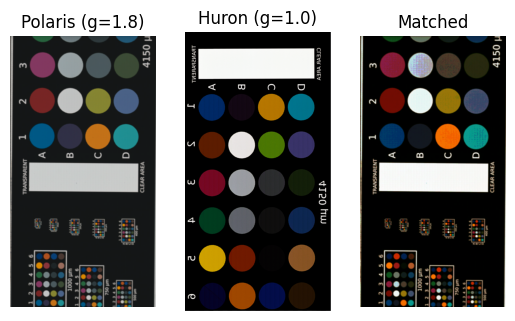

In [10]:
fig,axs = plt.subplots(ncols=3)
axs[0].imshow(polaris)
axs[0].set_title('Polaris (g=1.8)')
axs[0].axis("off")
axs[1].imshow(huron_101010)
axs[1].set_title('Huron (g=1.0)')
axs[1].axis("off")
axs[2].imshow(p_hl)
axs[2].set_title('Matched')
axs[2].axis("off")

(-0.5, 717.5, 1372.5, -0.5)

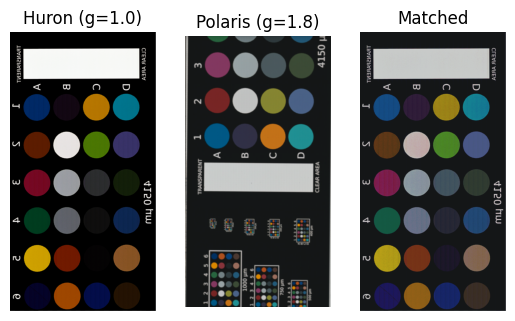

In [11]:
fig,axs = plt.subplots(ncols=3)
axs[0].imshow(huron_101010)
axs[0].set_title('Huron (g=1.0)')
axs[0].axis("off")
axs[1].imshow(polaris)
axs[1].set_title('Polaris (g=1.8)')
axs[1].axis("off")
axs[2].imshow(hl_p)
axs[2].set_title('Matched')
axs[2].axis("off")

(-0.5, 764.5, 1416.5, -0.5)

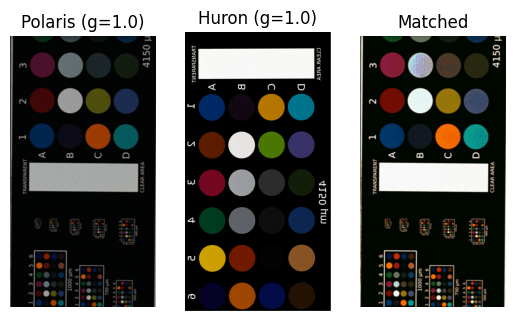

In [12]:
fig,axs = plt.subplots(ncols=3)
axs[0].imshow(polaris_linear)
axs[0].set_title('Polaris (g=1.0)')
axs[0].axis("off")
axs[1].imshow(huron_101010)
axs[1].set_title('Huron (g=1.0)')
axs[1].axis("off")
axs[2].imshow(pl_hl)
axs[2].set_title('Matched')
axs[2].axis("off")

(-0.5, 717.5, 1372.5, -0.5)

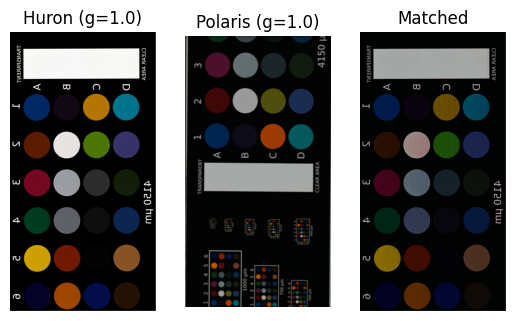

In [13]:
fig,axs = plt.subplots(ncols=3)
axs[0].imshow(huron_101010)
axs[0].set_title('Huron (g=1.0)')
axs[0].axis("off")
axs[1].imshow(polaris_linear)
axs[1].set_title('Polaris (g=1.0)')
axs[1].axis("off")
axs[2].imshow(hl_pl)
axs[2].set_title('Matched')
axs[2].axis("off")

(-0.5, 764.5, 1416.5, -0.5)

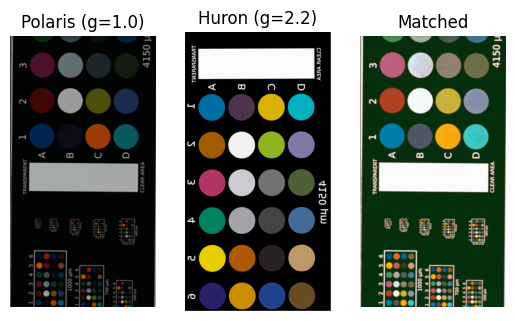

In [14]:
fig,axs = plt.subplots(ncols=3)
axs[0].imshow(polaris_linear)
axs[0].set_title('Polaris (g=1.0)')
axs[0].axis("off")
axs[1].imshow(huron22)
axs[1].set_title('Huron (g=2.2)')
axs[1].axis("off")
axs[2].imshow(pl_h)
axs[2].set_title('Matched')
axs[2].axis("off")

(-0.5, 717.5, 1372.5, -0.5)

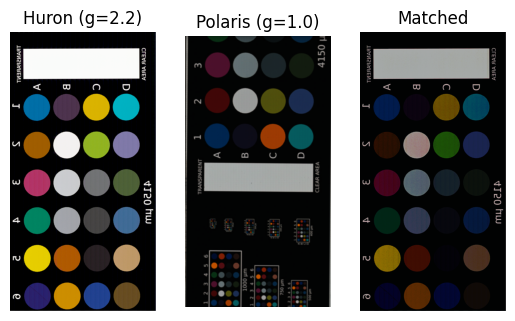

In [15]:
fig,axs = plt.subplots(ncols=3)
axs[0].imshow(huron22)
axs[0].set_title('Huron (g=2.2)')
axs[0].axis("off")
axs[1].imshow(polaris_linear)
axs[1].set_title('Polaris (g=1.0)')
axs[1].axis("off")
axs[2].imshow(h_pl)
axs[2].set_title('Matched')
axs[2].axis("off")

In [16]:
polaris.shape

(1417, 765, 3)

In [17]:
huron_101010.shape

(1373, 718, 3)